In [1]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
from collections import defaultdict
import surprise
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        #f_score = (2*precision*recall)/(precision+recall)
        
    return precision, recall#, f_score

In [3]:
def ndcg_at_k(predictions, k):
    dcgs = dict()
    idcgs = dict()
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
        
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        #estimated rank
        rank_est = np.arange(1, len(user_ratings[:k])+1)
        discount_est = np.log2(rank_est+1)
        
        #Relevance 
        rel = [np.power(2,true_r)-1 for (_, true_r) in user_ratings[:k]]
        
        dcgs[uid] = sum(rel/discount_est)
        
        # Sort user ratings by true value
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        
        #estimated rank
        rank_true = np.arange(1, len(user_ratings[:k])+1)
        discount_true = np.log2(rank_true+1)
        
        #Relevance 
        rel_true = [np.power(2,true_r)-1 for (_, true_r) in user_ratings[:k]]
        
        idcgs[uid] = sum(rel_true/discount_true)
        
    dcg = sum(dcgu for (_,dcgu) in dcgs.items())
    idcg = sum(idcgu for (_,idcgu) in idcgs.items())
    return dcg/idcg

In [4]:
train = pd.read_csv('train.csv') 

reader = surprise.Reader(rating_scale=(1, 10))
data = surprise.Dataset.load_from_df(train[['User-ID', 'ISBN', 'Book-Rating']], reader)

In [5]:
# Tunning on regularization term
regs = [0.02, 0.1, 0.5, 1, 1.5, 2]

In [6]:
test_ndcg = []
train_ndcg = []
test_precision = []
train_precision = []
test_recall = []
train_recall = []
train_f_score = []
test_f_score = []
k = 10
threshold = 7

In [7]:
for reg in regs:
    print ('\n regularization:{}'.format(reg))
    data.split(n_folds=4)
    algo = surprise.SVD(n_factors = 10 , lr_all = 0.001, reg_all = reg)
        
        
    precisions_train = []
    recalls_train = []
    f_scores_train = []
    ndcgs_train = []

    precisions_test = []
    recalls_test = []
    f_scores_test = []
    ndcgs_test = []
        
    for trainset, testset in data.folds():

        algo.train(trainset)

        predictions_train = algo.test(trainset.build_testset())
        precision_train, recall_train= precision_recall_at_k(predictions_train, k, threshold)
        ndcg_train = ndcg_at_k(predictions_train, k)

        precisions_train.append(precision_train)
        recalls_train.append(recall_train)
        f= 2*precision_train*recall_train/(precision_train+recall_train)
        f_scores_train.append(f)
        ndcgs_train.append(ndcg_train)


        predictions_test = algo.test(testset)
        precision_test, recall_test = precision_recall_at_k(predictions_test, k, threshold)
        ndcg_test = ndcg_at_k(predictions_test, k)

        precisions_test.append(precision_test)
        recalls_test.append(recall_test)
        f= 2*precision_test*recall_test/(precision_test+recall_test)
        f_scores_test.append(f)
        ndcgs_test.append(ndcg_test)    


    print ("\n Training Set accuracy:")
    print ("Precision: {}".format(np.mean(precisions_train)))
    train_precision.append(np.mean(precisions_train))
    print ("Recall: {}".format(np.mean(recalls_train)))
    train_recall.append(np.mean(recalls_train))
    print ("F-Score: {}".format(np.mean(f_scores_train)))
    train_f_score.append(np.mean(f_scores_train))
    print ("NDCG: {}".format(np.mean(ndcgs_train)))
    train_ndcg.append(np.mean(ndcgs_train))

    print ("\n Test Set accuracy:")
    print ("Precision: {}".format(np.mean(precisions_test)))
    test_precision.append(np.mean(precisions_test))
    print ("Recall: {}".format(np.mean(recalls_test)))
    test_recall.append(np.mean(recalls_test))
    print ("F-Score: {}".format(np.mean(f_scores_test)))
    test_f_score.append(np.mean(f_scores_test))
    print ("NDCG: {}".format(np.mean(ndcgs_test)))
    test_ndcg.append(np.mean(ndcgs_test))


 regularization:0.02

 Training Set accuracy:
Precision: 0.8852268690227474
Recall: 0.6544866671431825
F-Score: 0.7525655277230119
NDCG: 0.7897037936713237

 Test Set accuracy:
Precision: 0.8345469522649526
Recall: 0.9150148978713072
F-Score: 0.8729240990403917
NDCG: 0.8185833105369058

 regularization:0.1

 Training Set accuracy:
Precision: 0.8859595039149619
Recall: 0.6565476575910343
F-Score: 0.7541929228936023
NDCG: 0.7887959907757242

 Test Set accuracy:
Precision: 0.8324856245750069
Recall: 0.914643973118414
F-Score: 0.8716094482405863
NDCG: 0.8203848757062043

 regularization:0.5

 Training Set accuracy:
Precision: 0.8835691371445596
Recall: 0.6556221015555531
F-Score: 0.7527155222317454
NDCG: 0.7905738706197897

 Test Set accuracy:
Precision: 0.8310221408073633
Recall: 0.9176341427929464
F-Score: 0.8721748752423543
NDCG: 0.8205746560928922

 regularization:1

 Training Set accuracy:
Precision: 0.881727824672092
Recall: 0.6570973751965976
F-Score: 0.7530172569072897
NDCG: 0.791

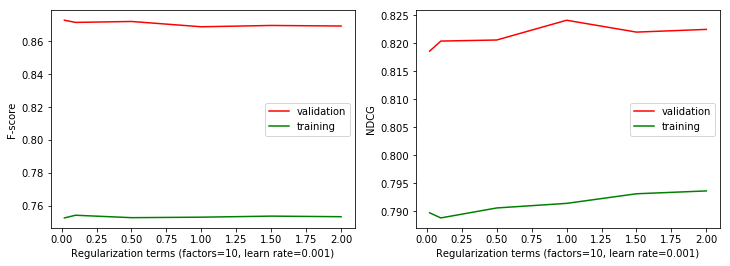

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(regs, test_f_score, 'r')
ax[0].plot(regs, train_f_score, 'g')
ax[0].set_xlabel('Regularization terms (factors=10, learn rate=0.001)')
ax[0].set_ylabel('F-score')
ax[0].legend(['validation','training'])
ax[1].plot(regs, test_ndcg, 'r')
ax[1].plot(regs, train_ndcg, 'g')
ax[1].set_xlabel('Regularization terms (factors=10, learn rate=0.001)')
ax[1].set_ylabel('NDCG')
ax[1].legend(['validation','training'])